## Análisis Exploratorio

In [1]:
# Conectarse a drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Declara directorio de trabajo.
HOME = '/content/drive/MyDrive/Maestria/Ciclo4/MW/Proyecto_mw/Proyecto/1. Codigo'
#path_data = HOME + '/data'
%cd {HOME}

/content/drive/MyDrive/Maestria/Ciclo4/MW/Proyecto_mw/Proyecto/1. Codigo


In [7]:
# Cargar librerías
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [8]:
# Leer la data
data = pd.read_csv('../data/tripadvisor_hoteles_cusco.csv')
data.head()

,f1_hotel,f2_costo,f3_cliente,f4_titulo,f5_contenido,f6_calificacion,f7_fecHosped,f8_page
0,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Wayne S,Neat little place in the center of Cusco.,Nice boutique hotel. Staff were very friendly ...,50,October 2023,1.0
1,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Leslie W,Perfect hotel and experience,My husband and I stayed here for two nights wh...,50,September 2023,1.0
2,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Mimi,Amazing stay at Cusco,We had a pleasant stay at this hotel for 3 nig...,50,September 2023,1.0
3,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",T0niaYVR,Amazing service and hospitality received,From the start of my stay to the end of it I f...,50,August 2023,1.0
4,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Natacha Talbot,Breathtaking place and walkable to everything,"If you come to Cusco, this is the place to sta...",50,July 2023,1.0


In [9]:
n_custom = data.f3_cliente.unique().shape[0]
n_hotels = data.f1_hotel.unique().shape[0]

print("\n Número de clientes = " + str(n_custom) + ' | Número de hoteles = ' +
     str(n_hotels))


 Número de clientes = 35333 | Número de hoteles = 1089


In [10]:
data.columns

Index(['f1_hotel', 'f2_costo', 'f3_cliente', 'f4_titulo', 'f5_contenido',
       'f6_calificacion', 'f7_fecHosped', 'f8_page'],
      dtype='object')

In [11]:
data.shape

(41486, 8)

In [13]:
data.groupby('f7_fecHosped').size().sort_index()

f7_fecHosped
 April 2005          3
 April 2006          9
 April 2007         19
 April 2008         38
 April 2009         54
                  ... 
 September 2019    365
 September 2020      3
 September 2021     40
 September 2022    106
 September 2023    112
Length: 236, dtype: int64

# Identificación del lenguaje
- Contenido del review
- Se utiliza la librería langid

In [ ]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=f98745486a92042d191ba67517188926c448951789e7d3990f7ff7a20b04dbad
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [ ]:
import langid
from langid.langid import LanguageIdentifier, model
id_model = LanguageIdentifier.from_modelstring(model, norm_probs=True)

In [ ]:
%%time
lang, prob_lang = [], []
for review in data.f5_contenido:
    lang.append(id_model.classify(review)[0])
    prob_lang.append(id_model.classify(review)[1])

data['languaje'] = lang
data['prob_lang'] = prob_lang
data.head()

CPU times: user 5min 41s, sys: 3min 37s, total: 9min 18s
Wall time: 6min 29s


,f1_hotel,f2_costo,f3_cliente,f4_titulo,f5_contenido,f6_calificacion,f7_fecHosped,f8_page,languaje,prob_lang
0,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Wayne S,Neat little place in the center of Cusco.,Nice boutique hotel. Staff were very friendly ...,50,October 2023,1.0,en,1.0
1,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Leslie W,Perfect hotel and experience,My husband and I stayed here for two nights wh...,50,September 2023,1.0,en,1.0
2,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Mimi,Amazing stay at Cusco,We had a pleasant stay at this hotel for 3 nig...,50,September 2023,1.0,en,1.0
3,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",T0niaYVR,Amazing service and hospitality received,From the start of my stay to the end of it I f...,50,August 2023,1.0,en,1.0
4,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Natacha Talbot,Breathtaking place and walkable to everything,"If you come to Cusco, this is the place to sta...",50,July 2023,1.0,en,1.0


In [ ]:
pd.value_counts(data.languaje)

en    40161
es     1025
pt      116
fr       69
it       24
de       18
ja       14
nl       12
la       12
zh        9
ko        8
ru        5
he        3
sv        3
mt        2
lt        1
se        1
as        1
gl        1
da        1
Name: languaje, dtype: int64

In [ ]:
pd.value_counts(data.languaje)/len(data)*100

en    96.806151
es     2.470713
pt     0.279612
fr     0.166321
it     0.057851
de     0.043388
ja     0.033746
nl     0.028925
la     0.028925
zh     0.021694
ko     0.019284
ru     0.012052
he     0.007231
sv     0.007231
mt     0.004821
lt     0.002410
se     0.002410
as     0.002410
gl     0.002410
da     0.002410
Name: languaje, dtype: float64

In [ ]:
data.to_csv('tripadvisor_hoteles_cusco_lang.csv', index = False)

### Nos quedamos solamente con los comentarios en inglés

In [ ]:
data_en = data[data.languaje == 'en']
data_en.shape

(40161, 10)

In [ ]:
##### Descripción de las caracteristicas del texto extraido.

In [ ]:
# Nùmero de tokens en el libro
def text_description(tokens):
    num_tokens = len(tokens)
    vocabulary_size = len(list(set(tokens)))
    rt = 1 - (vocabulary_size/num_tokens)
    print(f'El libro tiene {num_tokens} tokens')
    print(f'El vocabulario empleado en el libro es de {vocabulary_size} palabras')
    print(f'Riqueza del texto: {rt}')

In [ ]:
# You will have to download the set of stop words the first time
import nltk
nltk.download('stopwords')
# Load library
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# Create function using string.punctuation to remove all punctuation
import string
import numpy as np
import re
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Prrprocesamos el texto para calcular el tamaño del vocabulario, todo a minisculas y eliminamos signos de puntuación
clean_review = []
for review in data_en.f5_contenido:
    r = review.lower()
    # Apply function
    r = remove_punctuation(r) # Remover signos de puntuaciòn
    #r1 = [word for word in r if word not in stop_words]

    #print(review, '\n\n',  r, '\n\n', r1)
    clean_review.append(r)



In [ ]:
#data_en = data_en.drop('clean_review', axis  =1)

In [ ]:
data_en['clean_review'] = clean_review
data_en.head()

<ipython-input-31-dc3c903f4957>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_en['clean_review'] = clean_review


,f1_hotel,f2_costo,f3_cliente,f4_titulo,f5_contenido,f6_calificacion,f7_fecHosped,f8_page,languaje,prob_lang,clean_review
0,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Wayne S,Neat little place in the center of Cusco.,Nice boutique hotel. Staff were very friendly ...,50,October 2023,1.0,en,1.0,nice boutique hotel staff were very friendly a...
1,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Leslie W,Perfect hotel and experience,My husband and I stayed here for two nights wh...,50,September 2023,1.0,en,1.0,my husband and i stayed here for two nights wh...
2,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Mimi,Amazing stay at Cusco,We had a pleasant stay at this hotel for 3 nig...,50,September 2023,1.0,en,1.0,we had a pleasant stay at this hotel for 3 nig...
3,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",T0niaYVR,Amazing service and hospitality received,From the start of my stay to the end of it I f...,50,August 2023,1.0,en,1.0,from the start of my stay to the end of it i f...
4,Casa Cartagena Boutique Hotel & Spa,"PEN 1,120",Natacha Talbot,Breathtaking place and walkable to everything,"If you come to Cusco, this is the place to sta...",50,July 2023,1.0,en,1.0,if you come to cusco this is the place to stay...


In [ ]:
%%time
nltk.download('punkt')
all_tokens = []
#stem_tokens = []
for review in data_en.clean_review:
    for word in nltk.word_tokenize(review):
        all_tokens.append(word)
        #stem_tokens.append(porter.stem(word))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


CPU times: user 21.8 s, sys: 269 ms, total: 22.1 s
Wall time: 27.2 s


In [ ]:
# Load stop words
stop_words = stopwords.words('english')

# Remove stop words
all_tokens = [word for word in all_tokens if word not in stop_words]
all_tokens[0:5]

['nice', 'boutique', 'hotel', 'staff', 'friendly']

In [ ]:
text_description(all_tokens)

El libro tiene 2446397 tokens
El vocabulario empleado en el libro es de 54006 palabras
Riqueza del texto: 0.977924269854811


In [ ]:
# Terminos màs frecuentes
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
c_tokens = Counter(all_tokens) #count per v. entry
c_tokens

Counter({'nice': 15993,
         'boutique': 1390,
         'hotel': 41676,
         'staff': 27138,
         'friendly': 11122,
         'attentive': 1322,
         'interesting': 563,
         'selection': 610,
         'acrylic': 2,
         'furniture': 324,
         'seemed': 792,
         'place': 12878,
         'old': 2544,
         'colonial': 999,
         'building': 1849,
         'great': 22986,
         'location': 12583,
         'court': 203,
         'yard': 225,
         'good': 20617,
         'spa': 842,
         'area': 5732,
         'general': 2736,
         'really': 11689,
         'stay': 22540,
         'heart': 812,
         'cusco': 24287,
         'dear': 1818,
         'guest': 6943,
         'thanks': 3086,
         'preference': 386,
         'appreciated': 740,
         'comments': 5064,
         'us': 29924,
         'important': 1466,
         'recognize': 42,
         'beautifully': 646,
         'decorated': 1056,
         'maintained': 364,
      

In [ ]:
def terminos_frecuentes(tokens):
    # Convertir el contador en un DataFrame de Pandas
    df = pd.DataFrame.from_dict(tokens, orient='index', columns=['Frecuencia'])
    df.reset_index(inplace=True)
    df = df.rename(columns={'index': 'Término'})

    # Ordenar el DataFrame por frecuencia en orden descendente
    df = df.sort_values(by='Frecuencia', ascending=False)

    # Tomar los 10 términos más frecuentes
    top_10_terms = df.head(10)

    # Crear un gráfico de barras
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frecuencia', y='Término', data=top_10_terms, palette='viridis')
    plt.xlabel('Frecuencia')
    plt.ylabel('Término')
    plt.title('Top 10 Términos Más Frecuentes')
    plt.show()
    return df

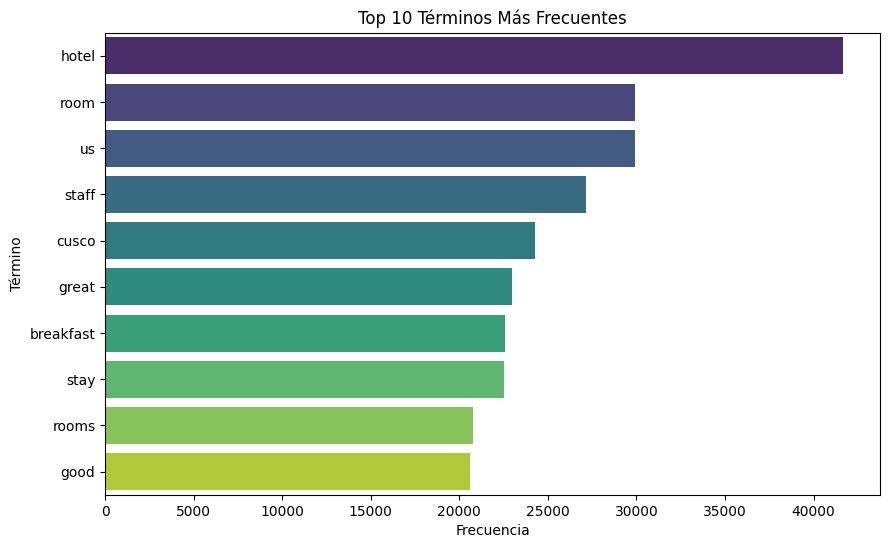

In [ ]:
df = terminos_frecuentes(c_tokens)

## Visulaizaciones

In [ ]:

# Importamos la librería WordCloud
from wordcloud import WordCloud
# Y otra que nos ayudará para la visualización de gráficos
import matplotlib.pyplot as plt

In [ ]:
data_en['clean_review']

0        nice boutique hotel staff were very friendly a...
1        my husband and i stayed here for two nights wh...
2        we had a pleasant stay at this hotel for 3 nig...
3        from the start of my stay to the end of it i f...
4        if you come to cusco this is the place to stay...
                               ...                        
41474    before checkin we already asked the room rate ...
41478    this jungle lodge was just what my husband and...
41479    this lodge was very basic hidden in the jungle...
41484    came in through a friends recommendation and e...
41485    i been there for 3 nights and the place its ni...
Name: clean_review, Length: 40161, dtype: object

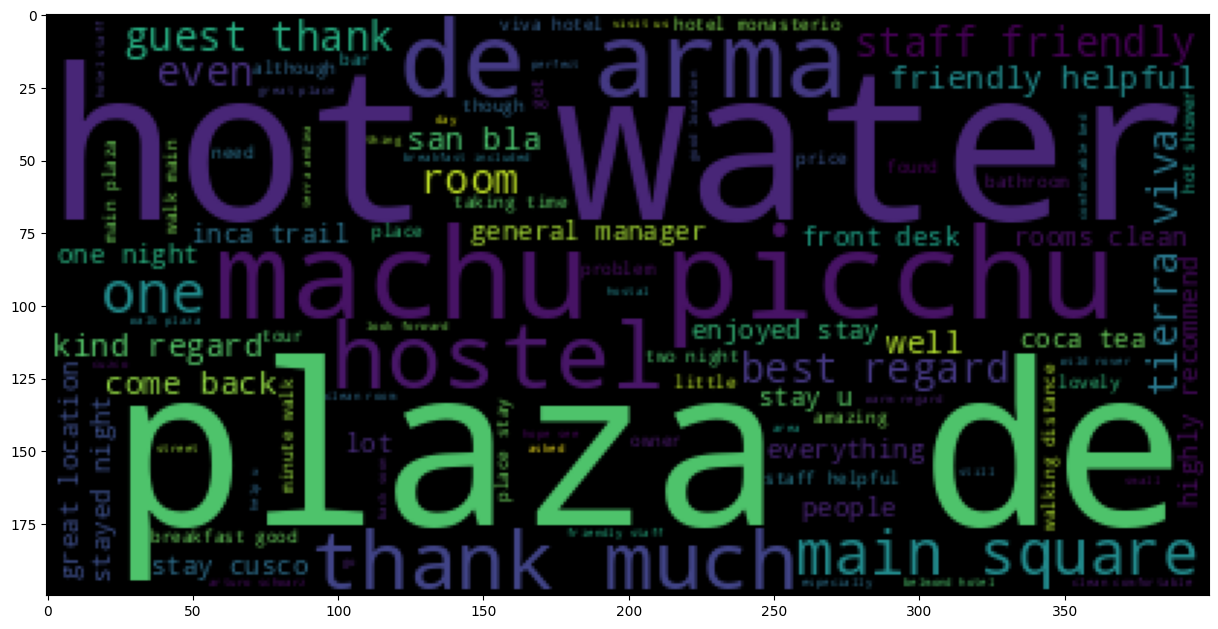

In [ ]:
# Generamos el "word cloud"
wordcloud = WordCloud().generate(" ".join(all_tokens))
plt.figure(figsize=[15,8])
plt.imshow(wordcloud)